<a href="https://colab.research.google.com/github/Aleksandr62aa/Test_task/blob/main/FC_NN_class_MNIST_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Classification of handwritten numbers by a fully connected neural network**

**Dataset MNIST**

**Importing libraries**

In [1]:
import torch
import random
import numpy as np
import torchvision.datasets
import cv2
from tqdm import tqdm

# Fixed seed
random.seed(7)
np.random.seed(7)
torch.manual_seed(7)
torch.cuda.manual_seed(7)
torch.backends.cudnn.deterministic = True

In [2]:
# Hyperparameters
batch_size = 100
num_epochs = 100
learning_rate = 1.0e-3

**Train Test dataset**

In [3]:
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False);

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 11.6MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 343kB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.20MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.48MB/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [4]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels;

/usr/local/lib/python3.11/dist-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.11/dist-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.11/dist-packages/torchvision/datasets/mnist.py:81: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.11/dist-packages/torchvision/datasets/mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [5]:
X_train.dtype, y_train.dtype, X_train.shape, y_train.shape

(torch.uint8, torch.int64, torch.Size([60000, 28, 28]), torch.Size([60000]))

In [ ]:
# X_train[0], y_train[0]

In [6]:
X_train = X_train.float()/255
X_test = X_test.float()/255

In [ ]:
# X_train[0]

In [7]:
X_train.shape, X_test.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

**Image**

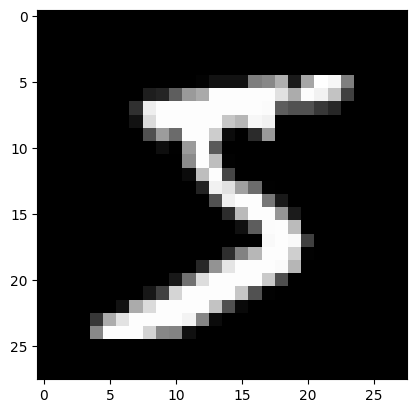

tensor(5)


In [8]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :], cmap='gray')
plt.show()
print(y_train[0])

In [9]:
X_train = X_train.reshape([-1, 28 * 28])
X_test = X_test.reshape([-1, 28 * 28])

In [10]:
X_train.shape, X_test.shape

(torch.Size([60000, 784]), torch.Size([10000, 784]))

In [11]:
# GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

**Model FC NN**

In [12]:
class MNISTNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super().__init__()
        self.fc1 = torch.nn.Linear(28 * 28, n_hidden_neurons)
        self.ac1 = torch.nn.Sigmoid()
        self.drop_out = torch.nn.Dropout()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 10)

    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.drop_out(x)
        x = self.fc2(x)
        return x

n_hidden_neurons = 100
mnist_net = MNISTNet(n_hidden_neurons).to(device)

In [13]:
mnist_net

MNISTNet(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (ac1): Sigmoid()
  (drop_out): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

**Loss function**

In [14]:
loss = torch.nn.CrossEntropyLoss()

**Optimizer**

In [15]:
optimizer = torch.optim.Adam(mnist_net.parameters(), lr=learning_rate)

**Training procedure**

In [16]:
train_accuracy_history = []
train_loss_history = []
test_accuracy_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in tqdm(range(num_epochs)): # цикл обучения по эпохам
    order = np.random.permutation(len(X_train)) # Случайным образом переставить последовательность

    for start_index in range(0, len(X_train), batch_size): # цикл обучения по бачам
        mnist_net.train()
        optimizer.zero_grad()

        batch_indexes = order[start_index:start_index+batch_size]

        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)

        preds = mnist_net.forward(X_batch)
        # preds = mnist_net(X_batch)

        # loss функция
        loss_value = loss(preds, y_batch)
        loss_value.backward()

        optimizer.step()
    # тестирование модели
    mnist_net.eval()
    train_preds = mnist_net.forward(X_train.to(device))
    test_preds = mnist_net.forward(X_test)

    # loss функция
    train_loss_history.append(loss(train_preds, y_train.to(device)).cpu().detach().numpy())

    # оценка метрики модели
    acc_train = (train_preds.argmax(dim=1) == y_train.to(device)).float().mean().cpu().detach().numpy()
    acc_test = (test_preds.argmax(dim=1) == y_test).float().mean().cpu().detach().numpy()
    train_accuracy_history.append(acc_train)
    test_accuracy_history.append(acc_test)


100%|██████████| 100/100 [01:44<00:00,  1.04s/it]


**Result test**

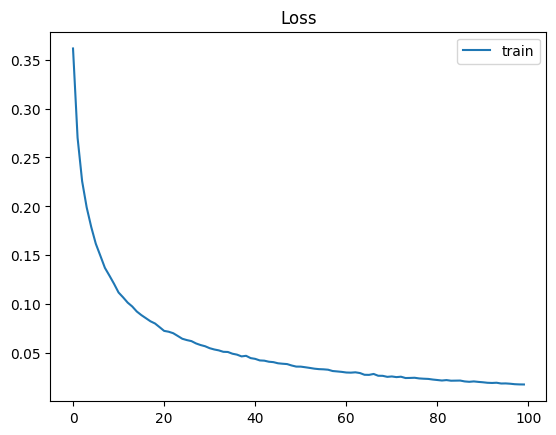

In [17]:
plt.plot(train_loss_history, label='train')
plt.legend(loc='best')
plt.title('Loss');

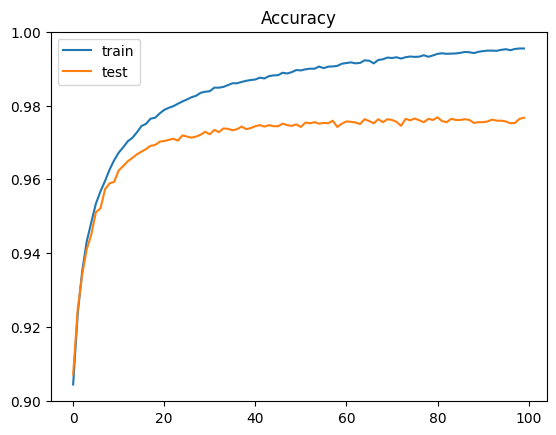

In [18]:
plt.plot(train_accuracy_history, label='train')
plt.plot(test_accuracy_history, label='test')
plt.legend(loc='best')
plt.title('Accuracy');

In [19]:
# Save the model state
st = mnist_net.state_dict()
torch.save(st, 'mnist_net.tar')
# torch.save(st, 'mnist_net.pth')

In [ ]:
# mnist_net.fc1.weight.data, mnist_net.fc1.bias.data